In [3]:
import numpy as np
from Bio import PDB
import matplotlib.pyplot as plt

In [4]:
def extract_structure(file_path):
    # Crea un oggetto PDBParser
    pdb_parser = PDB.PDBParser(QUIET=True)

    # Carica la struttura dal file PDB
    structure = pdb_parser.get_structure("mio_modello", file_path)
    return structure


def is_het(residue):
    res = residue.id[0]
    return res != " " and res != "W"


def extract_protein(structure):
    X = list()
    Y = list()
    
    for model in structure:
        for chain in model:
            for residue in chain:
                if is_het(residue):
                                continue
                for atom in residue:
                    #print(model.id,atom.get_coord(), "\t", atom.id)
                    X.append(atom.get_coord())
                    Y.append(atom.id)
    return np.array(X),np.array(Y)

def extract_ligand(structure):
    X = list()
    Y = list()
    for model in structure:
        for chain in model:
            for residue in chain:
                if not is_het(residue):
                                continue
                for atom in residue:
                    #print(model.id,atom.get_coord(), "\t", atom.id)
                    X.append(atom.get_coord())
                    Y.append(atom.id)
    return np.array(X),np.array(Y)


In [8]:
def voxelize(X, size):
    x_min,x_max = X[:,0].min(),X[:,0].max()
    y_min,y_max = X[:,1].min(),X[:,1].max()
    z_min,z_max = X[:,2].min(),X[:,2].max()
    grid = np.zeros((size,size,size))
    for x in X:
        x_pos = int((x[0] - x_min) / (x_max - x_min) * (size - 1) )
        y_pos = int((x[1] - y_min) / (y_max - y_min) * (size - 1) )
        z_pos = int((x[2] - z_min) / (z_max - z_min) * (size - 1) )
        grid[x_pos,y_pos,z_pos] = 1.
    return grid

In [9]:
def get_voxel_from_pdb(filename,size = 32):
    structure = extract_structure(filename)
    X,atoms = extract_protein(structure)
    return voxelize(X,size)

In [20]:
def get_anchors_from_pdb(filename):
    # Using readlines()
    file1 = open(filename, 'r')
    Lines = file1.readlines()

    count = 0
    # Strips the newline character
    A = list()
    for line in Lines:
        if line.startswith("ANCHOR"):
            A.append(np.array(line.split()[1:]))
    return np.array(A).astype(np.float32)

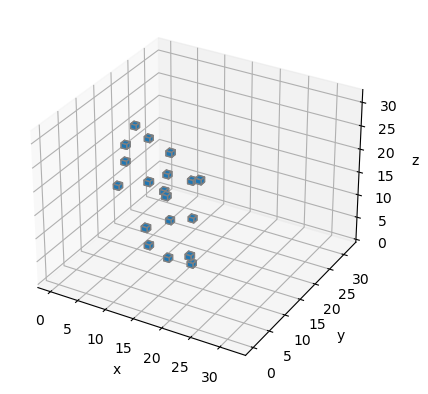

In [32]:
def get_anchors_and_voxels_from_pdb(filename,size = 32):
    structure = extract_structure(filename)
    X,atoms = extract_protein(structure)
    V = voxelize(X,size)
    A = get_anchors_from_pdb(filename)
    
    x_min,x_max = X[:,0].min(),X[:,0].max()
    y_min,y_max = X[:,1].min(),X[:,1].max()
    z_min,z_max = X[:,2].min(),X[:,2].max()
    
    grid = np.zeros((size,size,size))
    for x in A:
        x_pos = int((x[0] - x_min) / (x_max - x_min) * (size - 1) )
        y_pos = int((x[1] - y_min) / (y_max - y_min) * (size - 1) )
        z_pos = int((x[2] - z_min) / (z_max - z_min) * (size - 1) )
        grid[x_pos,y_pos,z_pos] = 1.
    
    return V,grid

G,A =  get_anchors_and_voxels_from_pdb(r"refined\1ezq\1ezq_pocket.ligen.pdb")


%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
def make_ax(grid=False):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.grid(grid)
    return ax

ax = make_ax(True)
ax.voxels(A, edgecolors='gray', shade=False)
plt.show()




In [33]:
import os
refined_folder = 'refined'
count = 0
grids = []
anchors = []
for root, dirnames, filenames in os.walk(refined_folder):
        for filename in filenames:
            if filename.endswith(('_pocket.ligen.pdb')):
                whole_path = '%s\\%s' % (root,filename)
                G,A = get_anchors_and_voxels_from_pdb(whole_path, 32)
                grids.append(G)
                anchors.append(A)
                print("%s done" % whole_path)
            count +=1 
        if count > 1000:
            break

refined\10gs\10gs_pocket.ligen.pdb done
refined\1a1e\1a1e_pocket.ligen.pdb done
refined\1a28\1a28_pocket.ligen.pdb done
refined\1a30\1a30_pocket.ligen.pdb done
refined\1a4k\1a4k_pocket.ligen.pdb done
refined\1a4r\1a4r_pocket.ligen.pdb done
refined\1a4w\1a4w_pocket.ligen.pdb done
refined\1a69\1a69_pocket.ligen.pdb done
refined\1a94\1a94_pocket.ligen.pdb done
refined\1a99\1a99_pocket.ligen.pdb done
refined\1a9m\1a9m_pocket.ligen.pdb done
refined\1a9q\1a9q_pocket.ligen.pdb done
refined\1aaq\1aaq_pocket.ligen.pdb done
refined\1add\1add_pocket.ligen.pdb done
refined\1adl\1adl_pocket.ligen.pdb done
refined\1ado\1ado_pocket.ligen.pdb done
refined\1afk\1afk_pocket.ligen.pdb done
refined\1afl\1afl_pocket.ligen.pdb done
refined\1ai4\1ai4_pocket.ligen.pdb done
refined\1ai5\1ai5_pocket.ligen.pdb done
refined\1ai7\1ai7_pocket.ligen.pdb done
refined\1aid\1aid_pocket.ligen.pdb done
refined\1aj7\1aj7_pocket.ligen.pdb done
refined\1ajn\1ajn_pocket.ligen.pdb done
refined\1ajp\1ajp_pocket.ligen.pdb done


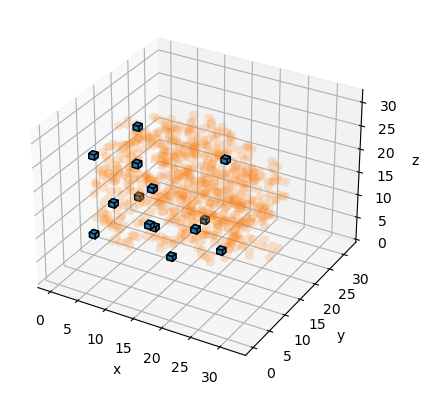

In [43]:
ax = make_ax(True)
ax.voxels(anchors[1], edgecolors='black', shade=False)
ax.voxels(grids[1], edgecolors='black', lw = 0., shade=False, alpha = 0.1 )

plt.show()




# Predictor

In [487]:
import jax.numpy as jnp
import jax
from jax import lax
from jax.lax import dynamic_slice

def predict_sigm(grid,W):
    G = grid.copy()
    
    def sigmoide(x):
        return (jnp.tanh(x) + 1.)/2.
    
    G = jax.vmap(
            lambda i:
            jax.vmap(
                lambda j:
                jax.vmap(
                    lambda k:
                        sigmoide( 
                                (dynamic_slice( G,(i - int(W.shape[0] / 2.) , j - int(W.shape[0] / 2.), k - int(W.shape[0] / 2.)) , 
                                      (W.shape[0],W.shape[1],W.shape[2]) ) * W).sum()
                        )
                )( jnp.arange( int(W.shape[0] / 2.) ,grid.shape[0] - int(W.shape[0] / 2.)).astype(int) )
            )( jnp.arange( int(W.shape[0] / 2.), grid.shape[0] - int(W.shape[0] / 2.)).astype(int) )
        )( jnp.arange( int(W.shape[0] / 2.), grid.shape[0] - int(W.shape[0] / 2.)).astype(int) )
    G = jnp.pad(G,int(W.shape[0]/2))
    return G

def predict_relu(grid,W):
    G = grid.copy()
    
    def sigmoide(x):
        return (jnp.tanh(x) + 1.)/2.
    
    def relu(x):
        return jnp.maximum(0,x)
    
    G = jax.vmap(
            lambda i:
            jax.vmap(
                lambda j:
                jax.vmap(
                    lambda k:
                        sigmoide( 
                                (dynamic_slice( G,(i - int(W.shape[0] / 2.) , j - int(W.shape[0] / 2.), k - int(W.shape[0] / 2.)) , 
                                      (W.shape[0],W.shape[1],W.shape[2]) ) * W).sum()
                        )
                )( jnp.arange( int(W.shape[0] / 2.) ,grid.shape[0] - int(W.shape[0] / 2.)).astype(int) )
            )( jnp.arange( int(W.shape[0] / 2.), grid.shape[0] - int(W.shape[0] / 2.)).astype(int) )
        )( jnp.arange( int(W.shape[0] / 2.), grid.shape[0] - int(W.shape[0] / 2.)).astype(int) )
    G = jnp.pad(G,int(W.shape[0]/2))
    return G

predict_relu = jax.jit(predict_relu)
predict_sigm = jax.jit(predict_sigm)


def multilayer_predict(G,W):
    A_hat = G
    for w in W[:-1]:
        A_hat = predict_relu(A_hat,w) 
    A_hat = predict_sigm(A_hat,W[-1])
    return A_hat

def loss(W,G,A):
    A_hat = multilayer_predict(G,W) * 2 - 1.
    A_adt = A * 2 - 1.
    positivi_totali = (A_adt == 1).sum()
    positivi_errore = jnp.sum( ((A_hat - A_adt)**2) * (A_adt == 1))
    negativi_totali = (A_adt == -1).sum()
    negativi_errore = jnp.sum( ((A_hat - A_adt)**2) * (A_adt == -1))
    
    return 0.5* (positivi_errore / positivi_totali + negativi_errore / negativi_totali)

loss = jax.jit(loss)
grad = jax.jit(jax.grad(loss))
W = [ np.random.normal(size = (7,7,7)) * 1e-3 for i in range(4) ]

epochs = 500
mom_w = [0*w for w in W]

for e in range(epochs):
    errors = list()
    for i in np.arange(len(grids))[np.random.choice(len(grids),len(grids),False)]:
        g = grad(W,grids[i],anchors[i])
        for i in range(len(W)):
            mom_w[i] = mom_w[i] * .999 - 0.00001* g[i]
            W[i] += mom_w[i]
        
        errors.append( loss(W,grids[i],anchors[i]))
    print(np.mean(errors))

0.69289124
0.6983527
0.6525646
0.62265116
0.6015658
0.56960493
0.5567923
0.522613
0.5275067
0.49948883
0.49620673
0.46115762
0.45088995
0.4742215
0.4718736
0.47801363
0.44964477
0.4266302
0.40716785
0.40156388
0.43018523
0.4840088
0.5136628
0.48675564
0.4494055
0.405954
0.38245323
0.3833214
0.3857089
0.3806348
0.36647537
0.35870448
0.3602608
0.36087584
0.34999013
0.33535627
0.32721016
0.32135364
0.32148746
0.32477173
0.32463264
0.33138317
0.3383798
0.34441257
0.34618315
0.33569902
0.3164451
0.30057064
0.2820146
0.26695976
0.26362622
0.25707197
0.26021045
0.26029927
0.26208797
0.26067558
0.25428236
0.25521722
0.24425653
0.23872936
0.2313401
0.23195545
0.23339589
0.23231438
0.23170221
0.2268946
0.2249537
0.22300716
0.22088978
0.22121511
0.22013052
0.21773317
0.21449293
0.2100335
0.20918824
0.21034886
0.21205394
0.21284108
0.21153264
0.20605256
0.20836449
0.20783892
0.21457495
0.21030019
0.21122946
0.20590483
0.20743833
0.19206767
0.1983741
0.1946545
0.19850913
0.190062
0.1906984
0.184717

<IPython.core.display.Javascript object>


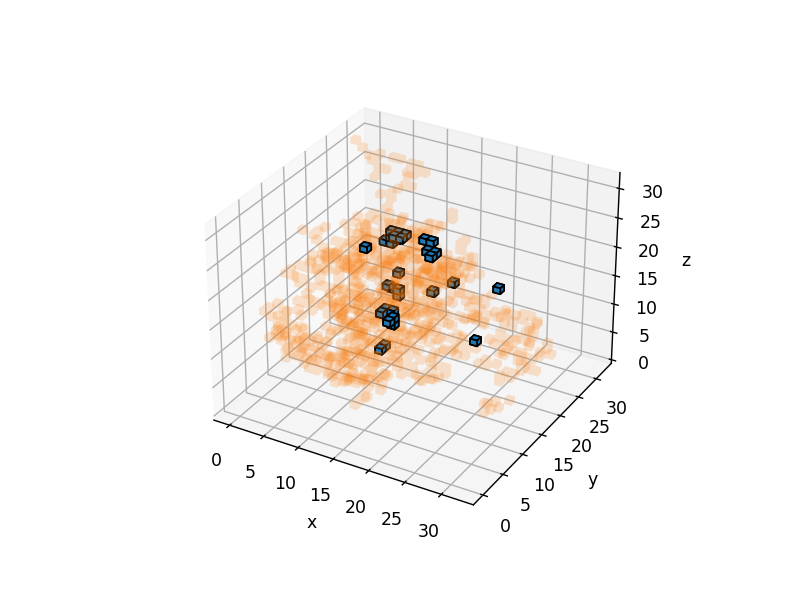

In [491]:
%matplotlib notebook
ax = make_ax(True)
sample = 5
pred   = np.array(multilayer_predict(grids[sample],W))
toplot = np.zeros(pred.shape)
for i in range(len(anchors[sample])):
    idx = np.unravel_index(pred.argmax(), pred.shape)
    toplot[idx] = 1.
    pred[idx] = -100.
    
ax.voxels( toplot , edgecolors='black', shade=False)
ax.voxels(grids[sample], edgecolors='black', lw = 0., shade=False, alpha = 0.1 )
plt.show()

<IPython.core.display.Javascript object>


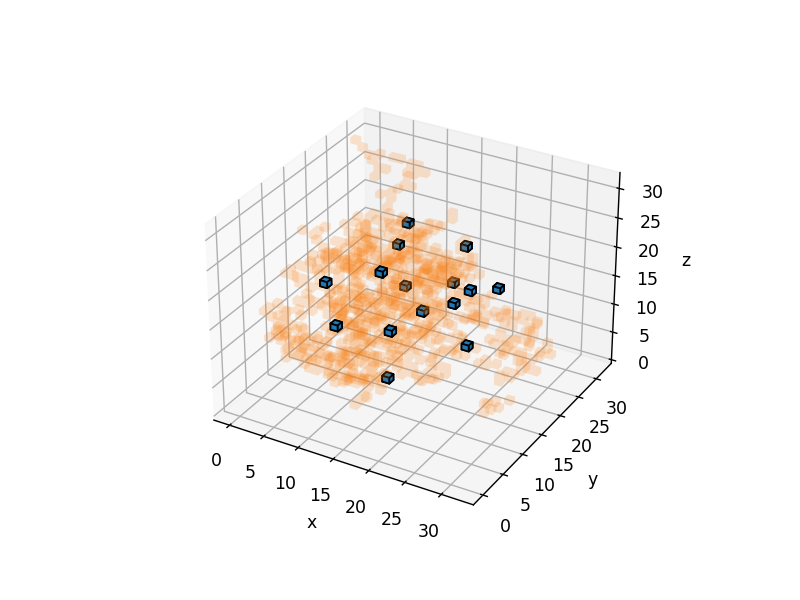

In [486]:
ax = make_ax(True)
ax.voxels(anchors[sample], edgecolors='black', shade=False)
ax.voxels(grids[sample], edgecolors='black', lw = 0., shade=False, alpha = 0.1 )
plt.show()